# Normality test

In this notebook, I go through several normality tests.   
 

The goal here is to test whether a given distribution is normal.   

The tests/steps done are:   
1. [Standarize data](#section1)
2. [Q - Q test](#section2)   
3. [Skew and kurtosis test](#section3)   
5. [Kolmogorov-Smirnov test](#section4)   
6. [$\chi^2$ test](#section5)

<a id='section1'></a>
## Standarize data
For this notebook, I use a dataset of documents, containing the document id, and its readability score.   
The readability score tells how complex is a text to be read.   
The contents of the dataset are not important here.   


In [1]:
# This is to print in markdown style
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

import pandas as pd

# Read dataset:
df = pd.read_csv('./data/db-readability-length.csv', index_col=0)
del df['Length']
X = df['Readability'].values
df.head()


,Readability
post id,
0,11.6
1,6.9
2,6.3
3,4.0
4,9.2


In [2]:
import numpy as np
# Sometimes it's important to remove outliers, as some of the tests don't work in presence of outliers
# Only keep data in range 1 to 99 th percentile:
X = df[df['Readability'].between(np.percentile(X,1), np.percentile(X,99), inclusive=True )].values


In [3]:
# Standarize and sort data
from sklearn.preprocessing import StandardScaler
import numpy as np
scaler = StandardScaler()

X = X.reshape(len(X))
X = scaler.fit_transform(X)
X = np.sort(X)



/Users/rangel/anaconda3/envs/cdips2017/lib/python3.6/site-packages/sklearn/preprocessing/data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/rangel/anaconda3/envs/cdips2017/lib/python3.6/site-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


For comparison, I also get random normal distributions A and B.

In [4]:
# Get also a normally distributed random sample:
from scipy.stats import norm

# Get random samples
n = len(X)

# Get random numbers, normaly distributed
A = norm.rvs(size=n)
A = np.sort(A)

# Second normal distribution, for comparison
B = norm.rvs(size=n)
B = np.sort(B)


Shift all matrices to take positive values.   
This is needed to perform the $chi^2$ test, which only works for positive values.   

Let's visualize the sample distributions we are working with in this notebook.   

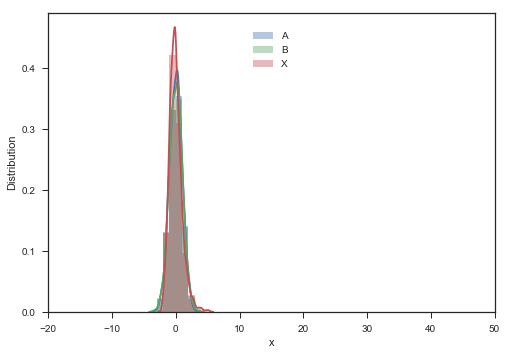

In [5]:
import matplotlib as plt
%matplotlib inline
import seaborn as sns
sns.set(style="ticks")

# Load the example dataset for Anscombe's quartet
#df = sns.load_dataset("anscombe")

bins = np.arange(-20,50,1)

# Show the results of a linear regression within each dataset
ax1 = sns.distplot(A,bins=bins,label='A')
ax2 = sns.distplot(B,bins=bins,label='B')
ax3 = sns.distplot(X,bins=bins,label='X')

plt.pyplot.xlabel('x')
plt.pyplot.ylabel('Distribution')
plt.pyplot.legend(bbox_to_anchor=(0.45, 0.95), loc=2, borderaxespad=0.)

plt.pyplot.xlim((-20,50))
plt.pyplot.show()

<a id='section2' ></a>

## Q - Q test   
This is a visual test to tell whether two distributions are similar.   
We plot the quartiles a given distribution vs. those of another distribution.  
In this case, I compare X vs. a normal distribution to tell whether X is normal.

In [6]:
def get_quartiles(X,Y):
    """Gets 100 quartiles for distributions X and Y
    returns Q1, Q2 with the corresponding quartiles"""
    # Get quartiles, 100 of them
    Q1 = []; Q2=[]
    nq = 10
    n1 = len(X)
    n2 = len(Y)
    for i in range(nq):
        j1 = int(i * n1/nq)
        j2 = int(i * n2/nq)
        # quartiles for the two distributions will be stored in X and Y respectively
        Q1.append(X[j1])
        Q2.append(Y[j2])
    Q1 = np.array(Q1)
    Q2 = np.array(Q2)
    return Q1, Q2

def plot_q_q(Q1,Q2):
    """Makes q-q plot
    Input Quartiles for two distributions"""
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots()
    line1, = ax.plot(Q1, Q1, '--', linewidth=2,
                 label='')
    line2, = ax.plot(Q1,Q2, linestyle = 'dotted', linewidth = 4,
                 label='Q-Q')
    #ax.legend(loc='lower right')
    ax.set_title('Q - Q plot')
    ax.set_ylabel('Distribution 2')
    ax.set_xlabel('Distribution 1')
    plt.show()

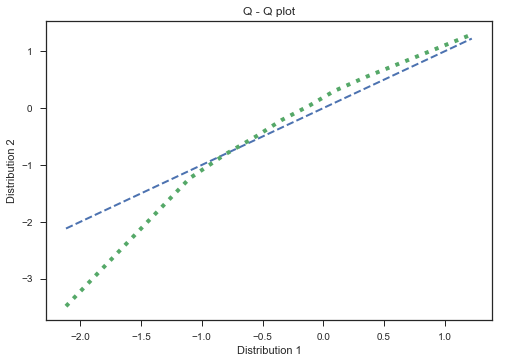

In [7]:
Q1, Q2 = get_quartiles(X,A)
plot_q_q(Q1,Q2)


With the above plot, we can see that Distribution 1 (X) is quite normal for values $> -1.0$. This deviates from normal at lower values, which will make most normality tests fail, as explain below.
  
For comparison, let's do the same test with a distribution that we know is normal:

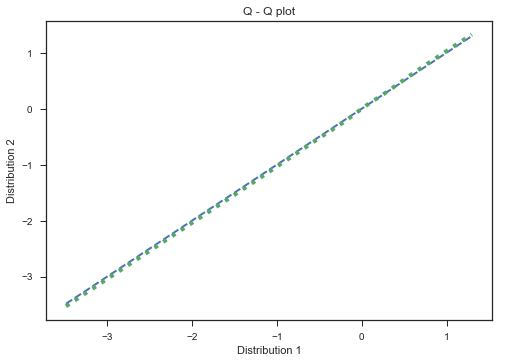

In [8]:
Q1, Q2 = get_quartiles(A,B)
plot_q_q(Q1,Q2)


<a id='section3'></a>
## Skew and Kurtosis test

Here I use the scipty stats implementation of the Ficher skew S and kurtosis K tests.   
We want to know if skew and kurtosis of our sample differ significantly from those of a normal distribution.   

### Skew test:
$H_0$: skew = 0   
$H_1$: skew $\neq$ 0

### Kurtosis test
$H_0$: kurtosis = 0   
$H_1$: kurtosis $\neq$ 0   

### p-values   
We can then obtain the z-scores using:    
$z_\mathrm{skewness} = \frac{S - 0}{\mathrm{SE}_\mathrm{skewness}}$

$z_\mathrm{kurtosis} = \frac{K - 0}{\mathrm{SE}_\mathrm{kurtosis}}$

The standard error for skewness and kurtosis can be obtained in any statistics package. Next, I use the implementation of numpy to get the p-values directly.

In [9]:
from scipy import stats

# Test our initial distribution
printmd('## Skew and Kurtosis tests for a random distribution')
printmd('#### Is our X distribution normal?')
print('Normal skew test teststat     = %6.3f pvalue = %6.4f' % stats.skewtest(X))
print('Normal kurtosis test teststat = %6.3f pvalue = %6.4f' % stats.kurtosistest(X))
printmd('**Conclusion** The pvalue for both tests are zero, meaning that we can reject $H_0$\n')
printmd('This conclusion is telling that X is not normal')

printmd('#### Comparison of 2 normal distributions')
printmd('For the sake of comparison, we repeat the test for a distribution which is actually normal')
printmd('Skew and Kurtosis tests for a normal random distribution')
print('Normal skew test teststat     = %6.3f pvalue = %6.4f' % stats.skewtest(A))
print('Normal kurtosis test teststat = %6.3f pvalue = %6.4f' % stats.kurtosistest(A))
printmd('**Conclusion** The pvalue for both tests are $>$ 0.05, so we accept $H_0$\n')
printmd('This means that A and B are similar, as expected since these two are actual normal distributions')



## Skew and Kurtosis tests for a random distribution

#### Is our X distribution normal?

Normal skew test teststat     = 21.912 pvalue = 0.0000
Normal kurtosis test teststat = 14.480 pvalue = 0.0000


**Conclusion** The pvalue for both tests are zero, meaning that we can reject $H_0$


This conclusion is telling that X is not normal

#### Comparison of 2 normal distributions

For the sake of comparison, we repeat the test for a distribution which is actually normal

Skew and Kurtosis tests for a normal random distribution

Normal skew test teststat     = -0.779 pvalue = 0.4360
Normal kurtosis test teststat = -0.810 pvalue = 0.4178


**Conclusion** The pvalue for both tests are $>$ 0.05, so we accept $H_0$


This means that A and B are similar, as expected since these two are actual normal distributions

<a id='section4'></a>
## Kolmogorov-Smirnov test   

This test relies on computing the larger distance between two CDF distributions.   
Let's look at the CDFs for a test X distribution and a normal distribution A, see [PDF-CDF](https://github.com/trangel/stats-with-python/blob/master//PDF-CDF.ipynb).   

-2.11920877783 5.32355633139 0.01


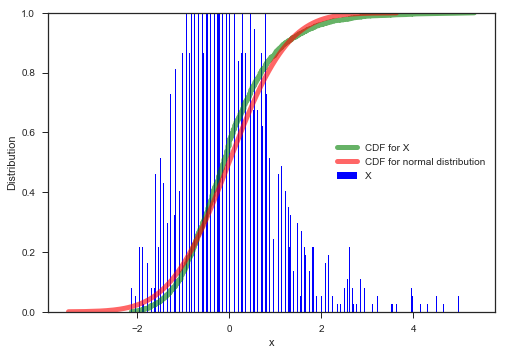

In [10]:
# Get PDF function:
import matplotlib.pyplot as plt
from scipy.stats import norm
rv = norm()

# calculate the proportional values of samples
P = 1. * np.arange(len(X)) / (len(X) - 1)

CDF2 = rv.cdf(A)
xmax = X.max()
xmin = X.min()
xstep = 0.01

print(xmin,xmax,xstep)

xx = np.arange(xmin,xmax,xstep)

fig, ax = plt.subplots()

ax.plot(X, P, 'g-', lw=5, alpha=0.6, label = 'CDF for X' )
n,bins,patches=ax.hist(X, bins=np.arange(xmin, xmax, xstep),normed=1,facecolor='blue',align='mid',label='X')

ax.plot(A, CDF2, 'r-', lw=5, alpha=0.6, label = 'CDF for normal distribution')

#plt.xlim(-3,7)
plt.ylim(0,1)

ax.legend(loc='right')
#ax.set_title('PDF function')
ax.set_ylabel('Distribution')
ax.set_xlabel('x')


plt.show()


In [11]:
stats.ks_2samp(X, A)

Ks_2sampResult(statistic=0.097000810591732045, pvalue=1.2335869241968664e-15)

The Kolmogorove-Smirnov test is also telling that X is significantly different from a normal distribution, although visually we can find that the CDF is quite normal (compare green and red lines above).    

As we saw in the Q-Q plot, only the left-end fraction of the data (lowest values) deviate from a normal distribution, which may be the reason why the Kurtosis, Skew and KS tests tell give a low p-value.    

Let's use now the $\chi^2$ test, a method robust enough to the presence of outliers, and which relies on all points of the distribution to determine normality. 

<a id='section5'></a>

## Chi-square test

Also called "Goodness of fit test".   
This is also used to test if two distributions are consistent.   


The test statistic (CV) is computed as    

$\chi^2 = \sum_i (O_i - E_i)^2/E_i$

where $O_i$ and $E_i$ are observed and expected frequency counts. 

after computing CV and degrees of freedom ($= n - 1$), we use the chi-square calculator to get the probability of P(chi2 $\leq$ CV) http://stattrek.com/online-calculator/chi-square.aspx

**Note** $\chi^2$ is the ratio between non negative values, so we need to shift our data to the positive scale before doing chi-square tests.

### Toy exercise  

Let's reproduce the example at
http://stattrek.com/chi-square-test/goodness-of-fit.aspx?Tutorial=AP

In [12]:
E=np.array([30,60,10])
O=np.array([50,45,5])

cv = np.sum((O-E)**2/E)
print(cv)
df=2
crit = stats.chi2.ppf(q = 0.95, # Find the critical value for 95% confidence*
                      df = df)   # *


print("Critical value for 95% confidence",crit)

p_value = float(1.0 - stats.chi2.cdf(x=cv, df=df))
print("P value %12.6f" % p_value)

19.5833333333
Critical value for 95% confidence 5.99146454711
P value     0.000056


Here we reproduce the findings in the web site, finding a small P value for this test.   
Let's test normality for our X distribution.   
This time we will compare X to a normal distribution with the mean value of X and same standard deviation.


In [13]:
# Let's fit X to a normal distribution:

# Get random numbers, normally distributed
# A will be now a normal distribution corresponding to X.
#(mu,sigma) = norm.fit(X)
#A = norm.rvs(loc=mu,scale=sigma**2,size=len(X))

A = norm.rvs(loc=X.mean(),scale=X.std(),size=len(X))
A = np.sort(A)

# Remember that all values need to be positive
eta=0.001 #small number to avoid numerical problems

# Get min values of distributions:
minval = min(A.min(),X.min()) 
if minval <= 0 :
    A = A - minval + eta
    X = X - minval + eta
    
#print(A.min(),A.mean(),A.std())
#print(X.min(),X.mean(),X.std())

In [14]:
# Let's compute the statistic:   
cv = np.sum( ( X - A )**2 / A )
df = len(X)-1
print("chi2 statistic",cv, "DF ", df)

crit_95 = stats.chi2.ppf(q = 0.95, # Find the critical value for 95% confidence*
                      df = df)   # *

print("Critical value for 95% confidence",crit_95)


p_value = float(1.0 - stats.chi2.cdf(x=cv, df=df))
print("P value %12.6f" % p_value)

printmd("The corresponding P($\,\chi^2 \leq $ CV) = 1, hence we accept $H_0$")


chi2 statistic 2203.82430023 DF  3700
Critical value for 95% confidence 3842.62353141
P value     1.000000


The corresponding P($\,\chi^2 \leq $ CV) = 1, hence we accept $H_0$

### Scipy's $\chi^2$ test

Let's do the same test, using the scipy's implementation of $\chi^2$ test





In [15]:
stats.chisquare(f_obs = X,f_exp = A)


Power_divergenceResult(statistic=2203.8243002327322, pvalue=1.0)

As you may notice, the $\chi^2$ test is telling that the test distribution (X) is similar to the sample normal distribution (A).   
In other words, that X is actually normal, contracting all previous tests.   

Let's dig more into this.   
A possible reason is that the Kolmogorov-Smirnov, skew and kurtosis tests need to be used with caution.    
These will fail in presence of data with outliers, as in actual distributions.    
So we can be more confident with the $\chi^2$ test results.   
Let's plot the X and A distributions to see how similar they look like, and convince to our selfs that X is quite normal distribution.

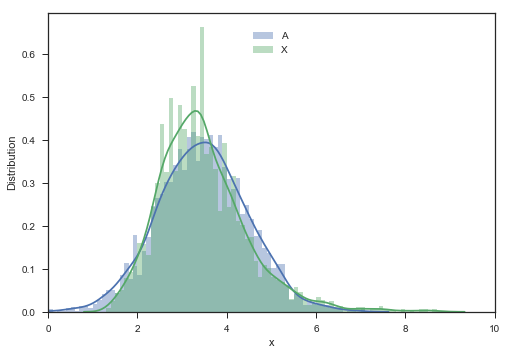

In [16]:
import matplotlib as plt
%matplotlib inline
import seaborn as sns
sns.set(style="ticks")

import matplotlib as plt
%matplotlib inline
import seaborn as sns
sns.set(style="ticks")

# Load the example dataset for Anscombe's quartet
#df = sns.load_dataset("anscombe")

bins = np.arange(0,10,0.1)

# Show the results of a linear regression within each dataset
ax1 = sns.distplot(A,bins=bins,label='A')
ax2 = sns.distplot(X,bins=bins,label='X')

plt.pyplot.xlabel('x')
plt.pyplot.ylabel('Distribution')
plt.pyplot.legend(bbox_to_anchor=(0.45, 0.95), loc=2, borderaxespad=0.)

plt.pyplot.xlim((0,10))
plt.pyplot.show()


# Summary   

* In this notebook, I revised a couple of methods to test if a distribution is normal.   
* I test a real distribution X from my Insight project as a toy model.   
* Skew, Kurtosis and Kolmogorov-Smirnov tests tell that the distribution is not normal.   
* $\chi^2$ test tells that this is indeed quite normal.    
* The disagreement between the test results is discussed.